You can run this notebook directly on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DaniAffCH/Vessel-Geometric-Transformers/blob/main/main.ipynb)

In [1]:
import sys

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git clone https://github.com/DaniAffCH/Vessel-Geometric-Transformers.git
    !mv Vessel-Geometric-Transformers/* . 
    !pip install -q -r requirements.txt
else:
    !pip install -q -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install


[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
[https://github.com/PyCQA/flake8] already up to date!
[https://github.com/pre-commit/mirrors-mypy] already up to date!
pre-commit installed at .git/hooks/pre-commit


Loading the configuration

In [2]:
from src.utils import load_config
import os
from config import DatasetConfig, TrainerConfig, BaselineConfig, GatrConfig

config_path = os.path.join("config","config.yaml")

config = load_config(config_path)
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
gatr_config: GatrConfig = config.gatr

Loading the dataset

In [3]:
from src.data import VesselDataModule

data = VesselDataModule(dataset_config)
print(f'Train size: {len(data.train_set)}')
print(f'Validation size: {len(data.val_set)}')
print(f'Test size: {len(data.test_set)}')
print(data.train_set[2])

Train size: 2999
Validation size: 599
Test size: 401
Data(pos=[8397, 3], wss=[8397, 3], pressure=[8397], face=[3, 16790], inlet_index=[214], label=Category.Single)


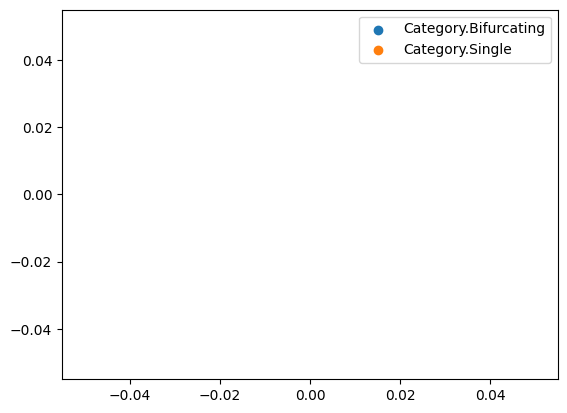

In [4]:
import seaborn as sns
from src.utils.definitions import Feature, Category
from src.utils.plotting import plot_data
import numpy as np
np.set_printoptions(threshold=np.inf)

sns.countplot(data.data.label)

pos, labels = data.extract_feature(Feature.POS)
wss, labels = data.extract_feature(Feature.WSS)
plot_data(wss, labels, Category)
# TODO continua data analysis

# Performing equivariance check

In [3]:
from src.lib.geometricAlgebraElements import GeometricAlgebraBase
from src.test.test_equivariance import TestEquivariance
import unittest

dl = data.train_dataloader()

batch = next(iter(dl)).data[0]
batch = batch.view(-1, GeometricAlgebraBase.GA_size)[:10]

TestEquivariance.INPUT_DATA = batch

suite = unittest.TestSuite()

suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestEquivariance))

test_runner = unittest.TextTestRunner(verbosity=0)

restResult = test_runner.run(suite)

/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)



✅ GeometricBilinearLayer passed all equivariance tests.                  [10 inputs, 100 checks each]

✅ EquiLinearLayer passed all equivariance tests.                  [10 inputs, 100 checks each]

✅ EquiNormLayer passed all equivariance tests.                  [10 inputs, 100 checks each]


FAIL: test_geomattention_layer (src.test.test_equivariance.TestEquivariance)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/src/test/test_equivariance.py", line 106, in test_geomattention_layer
    self.assertTrue(
AssertionError: False is not true : GeometricAttentionLayer failed the equivariance                     test for input 1

----------------------------------------------------------------------
Ran 5 tests in 5.692s

FAILED (failures=1)



✅ GatedGELU passed all equivariance tests.                  [10 inputs, 100 checks each]


# TODO: analisi dati preliminare. Classi bilanciate? Statistiche sul dataset? Qualche plot figo.

# TODO: HPO

# TODO: Analisi risultati!

In [1]:
import optuna
from src.trainer import VesselTrainer
from src.models import Gatr
from functools import partial

def objective(trial: optuna.trial.Trial, data: VesselDataModule) -> float:
    # We optimize the number of layers, hidden units in each layer and dropouts.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    output_dims = [
        trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True) for i in range(n_layers)
    ]

    model = Gatr(gatr_config)
    trainer = VesselTrainer(trainer_config)

    hyperparameters = dict(n_layers=n_layers, dropout=dropout, output_dims=output_dims)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=data)

    return trainer.callback_metrics["val_acc"].item()

pruner = optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
objective = partial(objective, data = data)
study.optimize(objective, n_trials=100, timeout=600)

/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'VesselDataModule' is not defined

Testing

In [5]:
trainer = VesselTrainer(trainer_config)
model = Gatr(gatr_config)
trainer.fit(model, data)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: danieleaffinita2000. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | hsProjection    | EquiLinearLayer   | 576    | train
1 | backbone        | ModuleList        | 25.3 K | tr

Epoch 0:  49%|████▉     | 370/750 [00:09<00:09, 40.72it/s, v_num=8hmp]     

/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [5]:
trainer.test(model, data)

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=19-step=15000.ckpt
/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any us

Testing DataLoader 0: 100%|██████████| 101/101 [00:00<00:00, 102.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │
│          test/f1          │            1.0            │
│         test/loss         │   5.252342452877201e-05   │
└───────────────────────────┴───────────────────────────┘

Training Loop

In [6]:
from src.trainer import VesselTrainer
from src.models import BaselineTransformer

trainer = VesselTrainer(trainer_config)

model = BaselineTransformer(baseline_config)

trainer.fit(model, data)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test/acc,▁
test/f1,▁
test/loss,▁
train/acc,▁▆▇▇▇███████████████
train/f1,▁▆▇▇▇███████████████
train/loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val/acc,▁▃▄▄▅▆██████████████
val/f1,▁▃▄▄▅▆██████████████
val/loss,█▇▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | TransformerEncoder | 2.2 K  | train
1 | embedder       | Linear             | 272    | tr

Epoch 0: 100%|██████████| 750/750 [00:18<00:00, 39.70it/s, v_num=pdr5, val/loss=0.0518, val/acc=0.987, val/f1=0.986, train/loss=0.194, train/acc=0.921, train/f1=0.922]

Metric val/loss improved. New best score: 0.052
Epoch 0, global step 750: 'val/loss' reached 0.05180 (best 0.05180), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=750.ckpt' as top 1


Epoch 1: 100%|██████████| 750/750 [00:20<00:00, 37.20it/s, v_num=pdr5, val/loss=0.0438, val/acc=0.988, val/f1=0.988, train/loss=0.0576, train/acc=0.981, train/f1=0.982]

Metric val/loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.044
Epoch 1, global step 1500: 'val/loss' reached 0.04383 (best 0.04383), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=1500.ckpt' as top 1


Epoch 2: 100%|██████████| 750/750 [00:20<00:00, 37.36it/s, v_num=pdr5, val/loss=0.0553, val/acc=0.977, val/f1=0.976, train/loss=0.0372, train/acc=0.988, train/f1=0.988]

Epoch 2, global step 2250: 'val/loss' was not in top 1


Epoch 3: 100%|██████████| 750/750 [00:19<00:00, 37.51it/s, v_num=pdr5, val/loss=0.00806, val/acc=0.997, val/f1=0.997, train/loss=0.0167, train/acc=0.994, train/f1=0.994]

Metric val/loss improved by 0.036 >= min_delta = 1e-05. New best score: 0.008
Epoch 3, global step 3000: 'val/loss' reached 0.00806 (best 0.00806), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=3-step=3000.ckpt' as top 1


Epoch 4: 100%|██████████| 750/750 [00:20<00:00, 37.39it/s, v_num=pdr5, val/loss=0.0104, val/acc=0.997, val/f1=0.997, train/loss=0.00523, train/acc=0.999, train/f1=0.999]

Epoch 4, global step 3750: 'val/loss' was not in top 1


Epoch 5: 100%|██████████| 750/750 [00:20<00:00, 37.39it/s, v_num=pdr5, val/loss=0.00832, val/acc=0.997, val/f1=0.997, train/loss=0.0835, train/acc=0.989, train/f1=0.989] 

Epoch 5, global step 4500: 'val/loss' was not in top 1


Epoch 6: 100%|██████████| 750/750 [00:20<00:00, 36.92it/s, v_num=pdr5, val/loss=0.00549, val/acc=0.997, val/f1=0.997, train/loss=0.00281, train/acc=1.000, train/f1=1.000]

Metric val/loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.005
Epoch 6, global step 5250: 'val/loss' reached 0.00549 (best 0.00549), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=6-step=5250.ckpt' as top 1


Epoch 7: 100%|██████████| 750/750 [00:20<00:00, 37.34it/s, v_num=pdr5, val/loss=0.0054, val/acc=0.997, val/f1=0.997, train/loss=0.00162, train/acc=1.000, train/f1=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005
Epoch 7, global step 6000: 'val/loss' reached 0.00540 (best 0.00540), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=6000.ckpt' as top 1


Epoch 8: 100%|██████████| 750/750 [00:20<00:00, 37.35it/s, v_num=pdr5, val/loss=0.00614, val/acc=0.997, val/f1=0.997, train/loss=0.000695, train/acc=1.000, train/f1=1.000]

Epoch 8, global step 6750: 'val/loss' was not in top 1


Epoch 9: 100%|██████████| 750/750 [00:20<00:00, 37.35it/s, v_num=pdr5, val/loss=0.0143, val/acc=0.995, val/f1=0.995, train/loss=0.000889, train/acc=1.000, train/f1=1.000] 

Epoch 9, global step 7500: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 750/750 [00:21<00:00, 35.55it/s, v_num=pdr5, val/loss=0.0173, val/acc=0.997, val/f1=0.997, train/loss=0.029, train/acc=0.994, train/f1=0.994]   

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.005. Signaling Trainer to stop.
Epoch 10, global step 8250: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 750/750 [00:21<00:00, 35.54it/s, v_num=pdr5, val/loss=0.0173, val/acc=0.997, val/f1=0.997, train/loss=0.029, train/acc=0.994, train/f1=0.994]


In [7]:
trainer.test(model, data)

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=6000.ckpt
/home/daniaffch/Desktop/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use 

Testing DataLoader 0: 100%|██████████| 101/101 [00:01<00:00, 72.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9975062608718872     │
│          test/f1          │     0.997481107711792     │
│         test/loss         │   0.010633878409862518    │
└───────────────────────────┴───────────────────────────┘

----